In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from urllib.parse import urlencode
from fbprophet import Prophet

import numpy as np

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

In [2]:
def download_data(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    result = response.json()['href']
    
    return result

download_link = 'https://disk.yandex.ru/d/EE0tMXFNgz7Wlg'

df = pd.read_csv(download_data(download_link))

In [3]:
df.isna().sum()

Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

In [4]:
df = df.astype({'Date': 'datetime64[ns]',
                 'AveragePrice': 'float'})\
        .rename(columns={'Date': 'ds',
                         'AveragePrice': 'y'})[['ds', 'y']]

In [5]:
df.head()

,ds,y
0,2015-01-04,1.75
1,2015-01-04,1.49
2,2015-01-04,1.68
3,2015-01-04,1.52
4,2015-01-04,1.64


In [6]:
# data for model check
predictions = 60

train_df = df[:-predictions]

In [7]:
pred_model = Prophet(weekly_seasonality=True, yearly_seasonality=True)

In [8]:
pred_model.fit(df=train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -187.935


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       29978.1    0.00201151       202.966           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       29982.5   2.65062e-05       100.964   2.045e-07       0.001      271  LS failed, Hessian reset 
     199       29982.8    0.00131488       385.978           1           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     274       29984.2    4.1928e-05       144.107   1.683e-07       0.001      427  LS failed, Hessian reset 
     299       29984.5   0.000367991       88.5254      0.2543           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     392         29985   3.18966e-05       97.6013   1.494e-07       0.001      618  LS failed, Hessian reset 
     399         29985    0.00019093  

In [9]:
future = pred_model.make_future_dataframe(periods=30)
forecast = pred_model.predict(future)

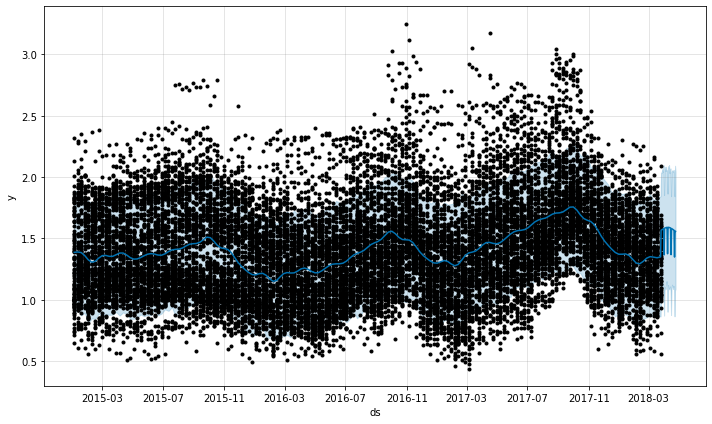

In [10]:
pred_model.plot(forecast);

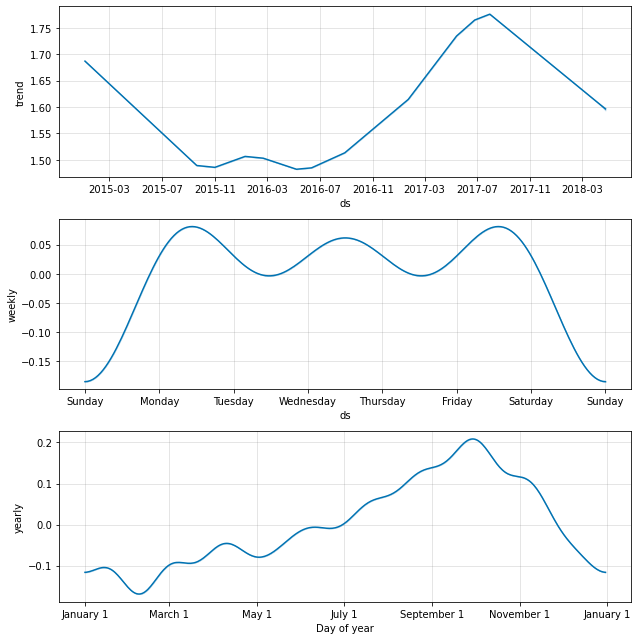

In [11]:
# plotting components
pred_model.plot_components(forecast);

In [12]:
def create_plot(df, frcst):
    iplot([
        go.Scatter(x=df['ds'], y=df['y'], name='fact'),
        go.Scatter(x=frcst['ds'], y=frcst['yhat'], name='prediction'),
        go.Scatter(x=frcst['ds'], y=frcst['yhat_upper'], fill='tonexty', mode='none', name='upper'),
        go.Scatter(x=frcst['ds'], y=frcst['yhat_lower'], fill='tonexty', mode='none', name='lower'),
        go.Scatter(x=frcst['ds'], y=frcst['trend'], name='trend')
    ])

In [13]:
create_plot(df, frcst=forecast)

In [14]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE –  20.669737084130723 %
MAE –  0.24234293593482406


In [15]:
# final forecast

prediction_days = 100
frcst = Prophet(weekly_seasonality=True, yearly_seasonality=False)
frcst.fit(df)
final_future = frcst.make_future_dataframe(periods=prediction_days)
final_forecast = frcst.predict(final_future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -234.061
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       29813.3    0.00938829       316.434           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       29856.5    0.00844624       445.907      0.1101      0.1101      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       29890.4   0.000855124       105.891           1           1      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     385       29895.1   5.28447e-05       197.359   3.735e-07       0.001      536  LS failed, Hessian reset 
     399       29896.1    0.00104279        822.18      0.4347      0.4347      553   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       29897.4    0.00167511    

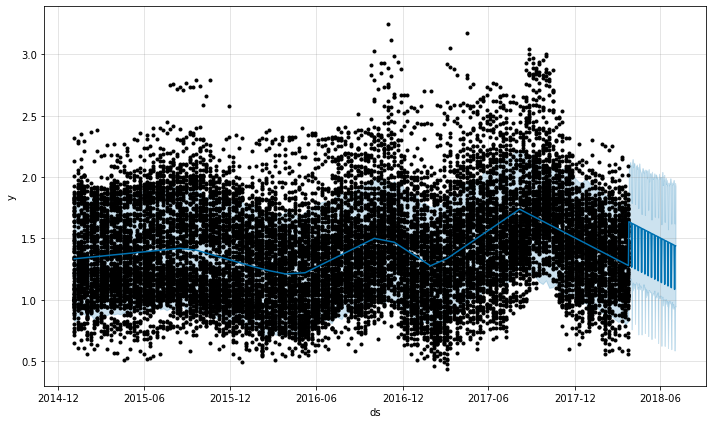

In [16]:
frcst.plot(final_forecast);

In [17]:
create_plot(df, final_forecast)